<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Slit

## Spec2: Extract1d()
<span style="color:red"> **Instruments Affected**</span>: MIRI

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.

* os, glob for general  OS operations
* numpy
* astropy.io for opening fits files
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot to generate plot
* json for editing json files
* crds for retrieving reference files as needed



[Top of Page](#title_ID)

In [1]:
import numpy as np
from numpy.testing import assert_allclose
import os
from glob import glob
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import astropy.io.fits as fits
import astropy.units as u
import jwst.datamodels as datamodels
from jwst.datamodels import RampModel, ImageModel
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline
from jwst.extract_1d import Extract1dStep
from gwcs.wcstools import grid_from_bounding_box
from jwst.associations.asn_from_list import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase


import json
import crds

from ci_watson.artifactory_helpers import get_bigdata

%matplotlib inline

<a id="intro_ID"></a>
# Introduction


In this notebook we will test the **extract1d()** step of Spec2Pipeline() for **LRS slit** observations.

Step description: https://jwst-pipeline.readthedocs.io/en/stable/jwst/extract_1d/index.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/extract_1d

### Short description of the algorithm

The extract1d() step does the following for POINT source observations:

* the code searches for the ROW that is the centre of the bounding box y-range
* using the WCS information attached to the data in assign_wcs() it will determine the COLUMN location of the target
* it computes the difference between this location and the centre of the bounding box x-range
* BY DEFAULT the exraction aperture will be centred on the target location, and the flux in the aperture will be summed row by row. The default extraction width is a constant value of 11 PIXELS.

In **Test 1** below, we load the json file that contains the default parameters, and override these to perform extraction over the full bounding box width for a single exposure. This tests the basic arithmetic of the extraction.

In **Test 2**, we use the pair of nodded exposures and pass these in an association to the Spec2Pipeline, allowing extract1d() to perform the default extraction on a nodded pair. This is a very typical LRS science use case.

[Top of Page](#title_ID)

<a id="data_ID"></a>
# Loading Data

We are using here a simulated LRS slit observation, generated with MIRISim v2.3.0 (as of Dec 2020). It is a simple along-slit-nodded observation of a point source (the input was modelled on the flux calibrator BD+60). LRS slit observations cover the full array. 


[Top of Page](#title_ID)

In [2]:
Slitfile1 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod1_v2.3.fits')
 
Slitfile2 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod2_v2.3.fits')

files = [Slitfile1, Slitfile2]



Collect configuration files locally if they aren't yet there.

In [3]:
if not os.path.exists('../cfg_files/'):
    os.mkdir('../cfg_files/')
    cfgs = collect_pipeline_cfgs.collect_pipeline_cfgs(dst='../cfg_files/')

<a id="pipeline_ID"></a>
# Run JWST Pipeline

First we run the data through the Detector1() pipeline to convert the raw counts into slopes. This should use the calwebb_detector1.cfg file. The output of this stage will then be run through the Spec2Pipeline. Extract_1d is the final step of this pipeline stage, so we will just run through the whole pipeline.

[Top of Page](#title_ID)

### Detector1Pipeline

In [4]:
det1 = []

# Run pipeline on both files
for ff in files:
    d1 = Detector1Pipeline.call(ff, save_results=True, config_file='../cfg_files/calwebb_detector1.cfg')
    det1.append(d1)

print(det1)



2021-02-01 16:00:32,560 - CRDS - ERROR -  Error determining best reference for 'pars-rscd_step'  =   Unknown reference type 'pars-rscd_step'
2021-02-01 16:00:58,945 - CRDS - ERROR -  Error determining best reference for 'pars-rscd_step'  =   Unknown reference type 'pars-rscd_step'


[<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>, <ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>]


### Spec2Pipeline

Next we go ahead to the Spec2 pipeline. At this stage we perform 2 tests:

1. run the Spec2 pipeline on one single exposure, extracting over the full bounding box width. we compare this with the manual extraction over the same aperture. this tests whether the pipeline is performing the correct arithmetic in the extraction procedure.
2. run the Spec2 pipeline on the nodded set of exposures. this mimics more closely how the pipeline will be run in automated way during routine operations. this will test whether the pipeline is finding the source positions, and is able to extract both nodded observations in the same way.

The initial steps will be the same for both tests and will be run on both initially.

First we run the Spec2Pipeline() **skipping** the extract1d() step.


In [5]:
spec2 = []
for dd in det1:
    s2 = Spec2Pipeline.call(dd.meta.filename, config_file='../cfg_files/calwebb_spec2.cfg', steps={"extract_1d": {"skip": True}})
    spec2.append(s2)


In [6]:
calfiles = glob('*_cal.fits')
print(calfiles)
photom = []
nods = []

for cf in calfiles:
    if 'nod1' in cf:
        nn = 'nod1'
    else:
        nn = 'nod2'
    ph = datamodels.open(cf)
    photom.append(ph)
    nods.append(nn)
    
print(photom)

['miri_lrs_slit_pt_nod2_v2_cal.fits', 'miri_lrs_slit_pt_nod1_v2_cal.fits']
[<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2_cal.fits>, <ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2_cal.fits>]


Retrieve the wcs information from the PHOTOM output file so we know the coordinates of the bounding box and the wavelength grid. We use the ``grid_from_bounding_box`` function to generate these grids. We convert the wavelength grid into a wavelength vector by averaging over each row. This works because LRS distortion is minimal, so lines of equal wavelength run along rows (not 100% accurate but for this purpose this is correct).

This cell performs a check that both nods have the same wavelength assignment over the full bounding box, which is expected.

In [7]:
lams = []

for ph,nn in zip(photom, nods):

    bbox_w = ph.meta.wcs.bounding_box[0][1] - ph.meta.wcs.bounding_box[0][0]
    bbox_ht = ph.meta.wcs.bounding_box[1][1] - ph.meta.wcs.bounding_box[1][0]
    print('Model bbox ({1}) = {0} '.format(ph.meta.wcs.bounding_box, nn))
    print('Model: Height x width of bounding box ({2})= {0} x {1} pixels'.format(bbox_ht, bbox_w, nn))

    x,y = grid_from_bounding_box(ph.meta.wcs.bounding_box)
    ra, dec, lam = ph.meta.wcs(x, y)

    lam_vec = np.mean(lam, axis=1)
    lams.append(lam_vec)
    
# check that the wavelength vectors for the nods are equal, then we can just work with one going forward
assert np.array_equal(lams[0], lams[1], equal_nan=True), "Arrays not equal!"

Model bbox (nod2) = ((302.5, 346.5), (6.5, 396.5)) 
Model: Height x width of bounding box (nod2)= 390.0 x 44.0 pixels
Model bbox (nod1) = ((302.5, 346.5), (6.5, 396.5)) 
Model: Height x width of bounding box (nod1)= 390.0 x 44.0 pixels


#### Test 1: Single exposure, full width extraction

To enable the extraction over the full width of the LRS slit bounding box, we have to edit the json parameters file and run the step with an override to the config file. We first run the Spec2Pipeline with its default settings, skipping the extract_1d() step.

**The next few steps will be executed with one of the nods only.** Next we perform a manual extraction by first extracting the bounding box portion of the array, and then summing up the values in each row over the full BB width. This returns the flux in MJy/sr, which we convert to Jy using the pixel area. A MIRI imager pixel measures 0.11" on the side.

**NOTE: as per default, the extract_1d() pipeline step will find the location of the target and offset the extraction window to be centred on the target. To extract the full slit, we want this to be disabled, so we set use_source_posn to False in the json input file.**

In [8]:
ph1 = photom[0]
nn = nods[0]
print('The next steps will be run only on {0}, the {1} exposure'.format(ph1.meta.filename, nn))

photom_sub = ph1.data[np.int(np.min(y)):np.int(np.max(y)+1), np.int(np.min(x)):np.int(np.max(x)+1)]
print('Cutout has dimensions ({0})'.format(np.shape(photom_sub)))
print('The cutout was taken from pixel {0} to pixel {1} in x'.format(np.int(np.min(x)),np.int(np.max(x)+1)))

xsub = np.sum(photom_sub, axis=1)

#remove some nans
lam_vec = lams[0]
xsub = xsub[~np.isnan(lam_vec)]
lam_vec = lam_vec[~np.isnan(lam_vec)]

# calculate the pixel area in sr
pix_scale = 0.11 * u.arcsec
pixar_as2 = pix_scale**2
pixar_sr = pixar_as2.to(u.sr)

# now convert flux from MJy/sr to Jy using the pixel area
if (ph1.meta.bunit_data == 'MJy/sr'):
    xsub_cal = xsub * pixar_sr.value * 1e6

print(len(lam_vec))


The next steps will be run only on miri_lrs_slit_pt_nod2_v2_cal.fits, the nod2 exposure
Cutout has dimensions ((390, 44))
The cutout was taken from pixel 303 to pixel 347 in x
387


Next we run the ``extract_1d()`` step on the same file, editing the configuration to sum up over the entire aperture as we did above. We load in the json file, make ajustments and run the step with a config file override option.

In [9]:
extreffile='jwst_miri_extract1d_0004.json'
basename=crds.core.config.pop_crds_uri(extreffile)
path=crds.locate_file(basename,"jwst")
with open(path) as json_ref:
    jsreforig = json.load(json_ref)
    jsrefdict = jsreforig.copy()
    jsrefdict['apertures'][0]['xstart'] = np.int(np.min(x))
    jsrefdict['apertures'][0]['xstop'] = np.int(np.max(x)) + 1
    jsrefdict['apertures'][0]['use_source_posn'] = False
    
    for element in jsrefdict['apertures']:
        element.pop('extract_width', None)
        element.pop('nod2_offset', None)

with open('extract1d_slit_full_spec2.json','w') as jsrefout:
    json.dump(jsrefdict,jsrefout,indent=4)

In [10]:
with open('extract1d_slit_full_spec2.cfg','w') as cfg:
    cfg.write('name = "extract_1d"'+'\n')
    cfg.write('class = "jwst.extract_1d.Extract1dStep"'+'\n')
    cfg.write(''+'\n')
    cfg.write('log_increment = 50'+'\n')
    cfg.write('smoothing_length = 0'+'\n')
    cfg.write('override_extract1d="extract1d_slit_full_spec2.json"'+'\n')

In [11]:
xsub_pipe = Extract1dStep.call(ph1, config_file='extract1d_slit_full_spec2.cfg', save_results=True)

If the step ran successfully, we can now look at the output and compare to our manual extraction spectrum. To ratio the 2 spectra we interpolate the manually extracted spectrum ``xsub_cal`` onto the pipeline-generated wavelength grid. 

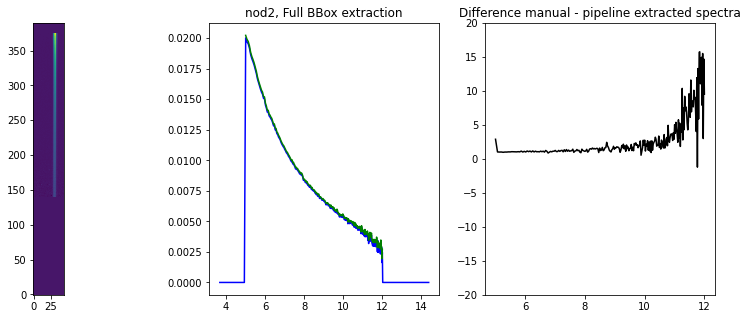

In [12]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=[14,5])
ax[0].imshow(photom_sub, origin='lower', interpolation='None')
ax[1].plot(lam_vec, xsub_cal, 'b-', label='manual extraction')
ax[1].plot(xsub_pipe.spec[0].spec_table['WAVELENGTH'], xsub_pipe.spec[0].spec_table['FLUX'], 'g-', label='pipeline extraction')
ax[1].set_title('{0}, Full BBox extraction'.format(nn))

#interpolate the two onto the same grid so we can look at the difference
f = interp1d(lam_vec, xsub_cal, fill_value='extrapolate')
ixsub_cal = f(xsub_pipe.spec[0].spec_table['WAVELENGTH'])

diff = ((xsub_pipe.spec[0].spec_table['FLUX'] - ixsub_cal) / xsub_pipe.spec[0].spec_table['FLUX']) * 100.

ax[2].plot(xsub_pipe.spec[0].spec_table['WAVELENGTH'], diff, 'k-')
ax[2].set_title('Difference manual - pipeline extracted spectra')
ax[2].set_ylim([-20., 20.])

fig.show()

We check that the ratio between the 2 is on average <= 1 per cent in the core range between 5 and 10 micron.

In [13]:
inds = (xsub_pipe.spec[0].spec_table['WAVELENGTH'] >= 5.0) & (xsub_pipe.spec[0].spec_table['WAVELENGTH'] <= 10.)
print(np.mean(diff[inds]))
assert np.mean(diff[inds]) <= 1.0, "Mean difference between pipeline and manual extraction >= 1 per cent in 5-10 um. CHECK."

1.370242952984757


AssertionError: Mean difference between pipeline and manual extraction >= 1 per cent in 5-10 um. CHECK.

------------------------------**END OF TEST PART 1**----------------------------------------------

#### Test 2: Nodded observation, two exposures

In this second test we use both nodded observations. In this scenarion, the nods are used as each other's background observations and we need to ensure that the extraction aperture is placed in the right position with a realistic aperture for both nods.

We will re-run the first steps of the Spec2Pipeline, so that the nods are used as each other's backgrounds. This requires creation of an association from which the Spec2Pipeline will be run. Then we will run them both through the extract_1d() step with the default parameters, checking:
* the location of the aperture
* the extraction width





In [ ]:
asn_files = [det1[0].meta.filename, det1[1].meta.filename]
asn = asn_from_list(asn_files, rule=DMSLevel2bBase, meta={'program':'test', 'target':'bd60', 'asn_pool':'test'})

# now add the opposite nod as background exposure:
asn['products'][0]['members'].append({'expname': 'miri_lrs_slit_pt_nod2_v2.3_rate.fits', 'exptype':'background'})
asn['products'][1]['members'].append({'expname': 'miri_lrs_slit_pt_nod1_v2.3_rate.fits', 'exptype':'background'})

# write this out to a json file
with open('lrs-slit-test_asn.json', 'w') as fp:
    fp.write(asn.dump()[1])

Now run the Spec2Pipeline with this association files as input, instead of the individual FITS files or datamodels.

In [ ]:
sp2 = Spec2Pipeline.call('lrs-slit-test_asn.json', save_results=True, config_file='../cfg_files/calwebb_spec2.cfg')

In [ ]:
x1dfiles = glob('*_x1d.fits')
print(x1dfiles)
x1ds = [datamodels.open(xf) for xf in x1dfiles]
fig = plt.figure(figsize=[15,5])

for x1 in x1ds:
    if 'nod1' in x1.meta.filename:
        nn = 'nod1'
    else: 
        nn = 'nod2'
    plt.plot(x1.spec[0].spec_table['WAVELENGTH'], x1.spec[0].spec_table['FLUX'], label=nn)

plt.plot(xsub_pipe.spec[0].spec_table['WAVELENGTH'], xsub_pipe.spec[0].spec_table['FLUX'], label='nod 1, full bbox extracted')
plt.legend(fontsize='large')
plt.grid()
plt.xlim([4.5, 12.5])
plt.xlabel('wavelength (micron)', fontsize='large')
plt.ylabel('Jy', fontsize='large')
fig.show()
    
    

What we will test for:
* the extracted spectra should be near-identical (chosen criteria: mean ration between the 2 <= 5%)


**Further tests to add:**
* perform a full verification of the extraction at the source position and with the same extraction width as in the parameters file.

**If the ``assert`` statement below passes, we consider the test a success.**



In [ ]:
inds = x1ds[0].spec[0].spec_table['FLUX'] > 0.00
ratio = x1ds[0].spec[0].spec_table['FLUX'][inds] / x1ds[1].spec[0].spec_table['FLUX'][inds]
infs = np.isinf(ratio-1.0)
assert np.mean(np.abs(ratio[~infs] - 1.)) <= 0.05, "Extracted spectra don't match!"

* Authors: B. Sargent/S. Kendrew, MIRI branch
* Last updated: Jan 11th, 2021